In [1]:
import pandas as pd

df = pd.read_csv("data.csv", encoding="latin1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
df = df.dropna(subset=["CustomerID"])


In [3]:
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]


In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [5]:
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]


In [6]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


In [8]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
}).reset_index()



In [10]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
}).reset_index()

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalAmount": "Monetary"
}, inplace=True)

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      126          1  77183.60
1     12347.0       47          3   1823.43
2     12348.0       49          3   1487.24
3     12350.0      110          1    334.40
4     12352.0       62          5   1561.81


In [11]:
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])


In [12]:
def segment(row):
    if row["R_score"] == 4 and row["F_score"] >= 3:
        return "Champions"
    elif row["F_score"] >= 3 and row["M_score"] >= 3:
        return "Loyal Customers"
    elif row["R_score"] >= 3:
        return "Potential Loyalists"
    elif row["R_score"] == 2:
        return "At Risk"
    else:
        return "Hibernating"

rfm["Segment"] = rfm.apply(segment, axis=1)


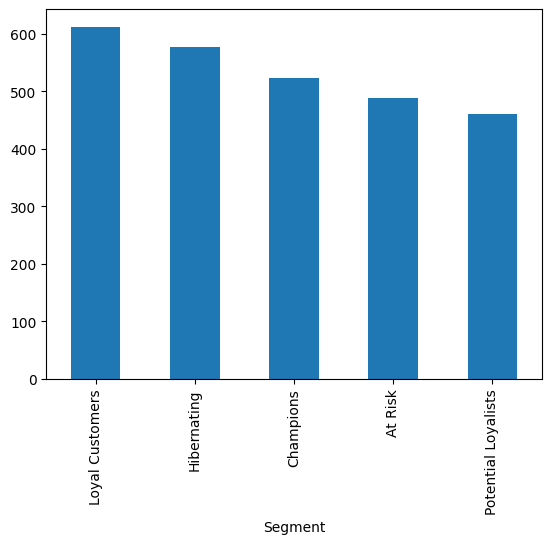

In [13]:
import matplotlib.pyplot as plt

rfm["Segment"].value_counts().plot(kind="bar")
plt.show()


In [14]:
rfm.to_csv("rfm_segments.csv", index=False)
